# Section 3.2 - Mars SmallSat Aerocapture - Tradespace Exploration

We use aerocapture feasibility charts to explore the design trade space for aerocapture at Mars using drag modulation aerocapture.

In [1]:
from AMAT.planet import Planet
from AMAT.vehicle import Vehicle

import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Polygon
import os

In [2]:
# Create a planet object
planet=Planet("MARS")
planet.h_skip = 120000.0

# Load an nominal atmospheric profile with height, temp, pressure, density data
planet.loadAtmosphereModel('../../../atmdata/Mars/mars-gram-avg.dat', 0 , 1 ,2, 3)

vinf_kms_array  = np.linspace( 0.0,   10.0,   11)
betaRatio_array = np.linspace( 1.0,   21.0 ,  11)

In [3]:
beta1 = 20.0
runID = 'mars-smallsat-dm'

In [4]:
v0_kms_array    = np.zeros(len(vinf_kms_array))
v0_kms_array[:] = np.sqrt(1.0*(vinf_kms_array[:]*1E3)**2.0 + 2*np.ones(len(vinf_kms_array))*planet.GM/(planet.RP+120.0*1.0E3))/1.0E3

overShootLimit_array  = np.zeros((len(v0_kms_array),len(betaRatio_array)))
underShootLimit_array = np.zeros((len(v0_kms_array),len(betaRatio_array)))
exitflag_os_array     = np.zeros((len(v0_kms_array),len(betaRatio_array)))
exitflag_us_array     = np.zeros((len(v0_kms_array),len(betaRatio_array)))
TCW_array             = np.zeros((len(v0_kms_array),len(betaRatio_array)))

In [ ]:
for i in range(0,len(v0_kms_array)):
    for j in range(0,len(betaRatio_array)):
        vehicle=Vehicle('DMVehicle', 100.0, beta1, 0.0, 1.767, 0.0, 0.35, planet)
        vehicle.setInitialState(120.0,0.0,0.0,v0_kms_array[i],0.0,-4.5,0.0,0.0)
        vehicle.setSolverParams(1E-6)
        vehicle.setDragModulationVehicleParams(beta1,betaRatio_array[j])

        underShootLimit_array[i,j], exitflag_us_array[i,j] = vehicle.findUnderShootLimitD(2400.0, 2.0, -80.0,-4.0,1E-10,400.0)
        overShootLimit_array[i,j] , exitflag_os_array[i,j] = vehicle.findOverShootLimitD (2400.0, 2.0, -80.0,-4.0,1E-10,400.0)

        TCW_array[i,j]    = overShootLimit_array[i,j] - underShootLimit_array[i,j]

        print('VINF: '+str(vinf_kms_array[i])+' km/s, BETA RATIO: '+str(betaRatio_array[j])+' TCW: '+str(TCW_array[i,j])+' deg.')

np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'vinf_kms_array.txt',vinf_kms_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'v0_kms_array.txt',v0_kms_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'betaRatio_array.txt',betaRatio_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'overShootLimit_array.txt',overShootLimit_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'exitflag_os_array.txt',exitflag_os_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'underShootLimit_array.txt',underShootLimit_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'exitflag_us_array.txt',exitflag_us_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'TCW_array.txt',TCW_array)

In [16]:
acc_net_g_max_array       = np.zeros((len(v0_kms_array),len(betaRatio_array)))
stag_pres_atm_max_array   = np.zeros((len(v0_kms_array),len(betaRatio_array)))
q_stag_total_max_array    = np.zeros((len(v0_kms_array),len(betaRatio_array)))
heatload_max_array        = np.zeros((len(v0_kms_array),len(betaRatio_array)))


underShootLimit_array = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'underShootLimit_array.txt')
overShootLimit_array = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'overShootLimit_array.txt')

for i in range(0,len(v0_kms_array)):
    for j in range(0,len(betaRatio_array)):
        vehicle=Vehicle('DMVehicle', 100.0, beta1, 0.0, 1.767, 0.0, 0.35, planet)
        vehicle.setInitialState(120.0,0.0,0.0,v0_kms_array[i],0.0,overShootLimit_array[i,j],0.0,0.0)
        vehicle.setSolverParams(1E-6)

        vehicle.propogateEntry (2400.0, 2.0, 0.0)

        # Extract and save variables to plot
        t_min_os         = vehicle.t_minc
        h_km_os          = vehicle.h_kmc
        acc_net_g_os     = vehicle.acc_net_g
        q_stag_con_os    = vehicle.q_stag_con
        q_stag_rad_os    = vehicle.q_stag_rad
        rc_os            = vehicle.rc
        vc_os            = vehicle.vc
        stag_pres_atm_os = vehicle.computeStagPres(rc_os,vc_os)/(1.01325E5)
        heatload_os      = vehicle.heatload


        vehicle=Vehicle('DMVehicle', 100.0, beta1, 0.0, 1.767, 0.0, 0.35, planet)
        vehicle.setInitialState(120.0,0.0,0.0,v0_kms_array[i],0.0,underShootLimit_array[i,j],0.0,0.0)
        vehicle.setSolverParams( 1E-6)

        vehicle.propogateEntry (2400.0, 2.0, 0.0)

        # Extract and save variable to plot
        t_min_us         = vehicle.t_minc
        h_km_us          = vehicle.h_kmc
        acc_net_g_us     = vehicle.acc_net_g
        q_stag_con_us    = vehicle.q_stag_con
        q_stag_rad_us    = vehicle.q_stag_rad
        rc_us            = vehicle.rc
        vc_us            = vehicle.vc
        stag_pres_atm_us = vehicle.computeStagPres(rc_us,vc_us)/(1.01325E5)
        heatload_us      = vehicle.heatload

        q_stag_total_os  = q_stag_con_os + q_stag_rad_os
        q_stag_total_us  = q_stag_con_us + q_stag_rad_us

        acc_net_g_max_array[i,j]      = max(max(acc_net_g_os),max(acc_net_g_os))
        stag_pres_atm_max_array[i,j]  = max(max(stag_pres_atm_os),max(stag_pres_atm_os))
        q_stag_total_max_array[i,j]   = max(max(q_stag_total_os),max(q_stag_total_us))
        heatload_max_array[i,j]       = max(max(heatload_os),max(heatload_os))

        print("V_infty: "+str(vinf_kms_array[i])+" km/s"+", BR: "+str(betaRatio_array[j])+" G_MAX: "+str(acc_net_g_max_array[i,j])+" QDOT_MAX: "+str(q_stag_total_max_array[i,j])+" J_MAX: "+str(heatload_max_array[i,j])+" STAG. PRES: "+str(stag_pres_atm_max_array[i,j]))

np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'acc_net_g_max_array.txt',acc_net_g_max_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'stag_pres_atm_max_array.txt',stag_pres_atm_max_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'q_stag_total_max_array.txt',q_stag_total_max_array)
np.savetxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'heatload_max_array.txt',heatload_max_array)

V_infty: 0.0 km/s, BR: 1.0 G_MAX: 0.8802169883233952 QDOT_MAX: 12.299433180911738 J_MAX: 2452.610893056963 STAG. PRES: 0.001708753559306077
V_infty: 0.0 km/s, BR: 3.0 G_MAX: 0.8802169883233952 QDOT_MAX: 15.798017276304611 J_MAX: 2452.610893056963 STAG. PRES: 0.001708753559306077
V_infty: 0.0 km/s, BR: 5.0 G_MAX: 0.8802169883233952 QDOT_MAX: 17.258172599537417 J_MAX: 2452.610893056963 STAG. PRES: 0.001708753559306077
V_infty: 0.0 km/s, BR: 7.0 G_MAX: 0.8802169883233952 QDOT_MAX: 18.099831481865703 J_MAX: 2452.610893056963 STAG. PRES: 0.001708753559306077
V_infty: 0.0 km/s, BR: 9.0 G_MAX: 0.8802169883233952 QDOT_MAX: 18.702861979243437 J_MAX: 2452.610893056963 STAG. PRES: 0.001708753559306077
V_infty: 0.0 km/s, BR: 11.0 G_MAX: 0.8802169883233952 QDOT_MAX: 19.157507566573663 J_MAX: 2452.610893056963 STAG. PRES: 0.001708753559306077
V_infty: 0.0 km/s, BR: 13.0 G_MAX: 0.8802169883233952 QDOT_MAX: 19.52223610157443 J_MAX: 2452.610893056963 STAG. PRES: 0.001708753559306077
V_infty: 0.0 km/s, 

V_infty: 5.0 km/s, BR: 9.0 G_MAX: 3.7872559881702705 QDOT_MAX: 62.18294269366363 J_MAX: 4922.900201062396 STAG. PRES: 0.007342348590774492
V_infty: 5.0 km/s, BR: 11.0 G_MAX: 3.7872559881702705 QDOT_MAX: 63.34656454184943 J_MAX: 4922.900201062396 STAG. PRES: 0.007342348590774492
V_infty: 5.0 km/s, BR: 13.0 G_MAX: 3.7872559881702705 QDOT_MAX: 64.27008443073703 J_MAX: 4922.900201062396 STAG. PRES: 0.007342348590774492
V_infty: 5.0 km/s, BR: 15.0 G_MAX: 3.7872559881702705 QDOT_MAX: 64.99829582271471 J_MAX: 4922.900201062396 STAG. PRES: 0.007342348590774492
V_infty: 5.0 km/s, BR: 17.0 G_MAX: 3.7872559881702705 QDOT_MAX: 65.73133296348114 J_MAX: 4922.900201062396 STAG. PRES: 0.007342348590774492
V_infty: 5.0 km/s, BR: 19.0 G_MAX: 3.7872559881702705 QDOT_MAX: 66.30766668470055 J_MAX: 4922.900201062396 STAG. PRES: 0.007342348590774492
V_infty: 5.0 km/s, BR: 21.0 G_MAX: 3.7872559881702705 QDOT_MAX: 66.74041666826393 J_MAX: 4922.900201062396 STAG. PRES: 0.007342348590774492
V_infty: 6.0 km/s, BR

V_infty: 10.0 km/s, BR: 17.0 G_MAX: 14.304598311664126 QDOT_MAX: 281.9513743438992 J_MAX: 11216.931808408366 STAG. PRES: 0.02770830881406925
V_infty: 10.0 km/s, BR: 19.0 G_MAX: 14.304598311664126 QDOT_MAX: 283.8000991043289 J_MAX: 11216.931808408366 STAG. PRES: 0.02770830881406925
V_infty: 10.0 km/s, BR: 21.0 G_MAX: 14.304598311664126 QDOT_MAX: 285.13162284891297 J_MAX: 11216.931808408366 STAG. PRES: 0.02770830881406925


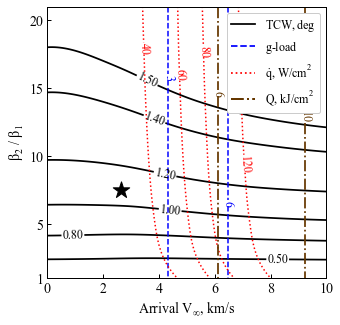

In [14]:
x = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'vinf_kms_array.txt')
y = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'betaRatio_array.txt')

Z1 = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'TCW_array.txt')
G1 = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'acc_net_g_max_array.txt')
Q1 = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'q_stag_total_max_array.txt')
H1 = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'heatload_max_array.txt')
S1 = np.loadtxt('../../../data/acta-astronautica/smallsat-mission-concepts/mars/'+runID+'stag_pres_atm_max_array.txt')


f1 = interpolate.interp2d(x, y, np.transpose(Z1), kind='cubic')
g1 = interpolate.interp2d(x, y, np.transpose(G1), kind='cubic')
q1 = interpolate.interp2d(x, y, np.transpose(Q1), kind='cubic')
h1 = interpolate.interp2d(x, y, np.transpose(H1), kind='cubic')
s1 = interpolate.interp2d(x, y, np.transpose(S1), kind='cubic')


x_new =  np.linspace( 0.0,   10,  110)
y_new =  np.linspace( 0.0,   21 ,110)

z1_new =  np.zeros((len(x_new),len(y_new)))
g1_new =  np.zeros((len(x_new),len(y_new)))
q1_new =  np.zeros((len(x_new),len(y_new)))
h1_new =  np.zeros((len(x_new),len(y_new)))
s1_new =  np.zeros((len(x_new),len(y_new)))

for i in range(0,len(x_new)):
    for j in range(0,len(y_new)):

        z1_new[i,j] = f1(x_new[i],y_new[j])
        g1_new[i,j] = g1(x_new[i],y_new[j])
        q1_new[i,j] = q1(x_new[i],y_new[j])
        h1_new[i,j] = h1(x_new[i],y_new[j])
        s1_new[i,j] = s1(x_new[i],y_new[j])


Z1 = z1_new
G1 = g1_new
Q1 = q1_new
S1 = s1_new
H1 = h1_new/1000.0

X, Y = np.meshgrid(x_new, y_new)

Zlevels = np.array([0.5, 0.80, 1.0, 1.20, 1.40, 1.50])

Glevels = np.array([3, 6])
Qlevels = np.array([40, 60, 80, 120])
Hlevels = np.array([6, 10])


fig = plt.figure()
fig.set_size_inches([5, 5])
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.xlim([0.0,10.0])
plt.ylim([1.0,21.0])


ZCS1 = plt.contour(X, Y, np.transpose(Z1), levels=Zlevels, colors='black')

plt.clabel(ZCS1, inline=1, fontsize=12, colors='black',fmt='%.2f',inline_spacing=1)
ZCS1.collections[0].set_linewidths(1.75)
ZCS1.collections[1].set_linewidths(1.75)
ZCS1.collections[2].set_linewidths(1.75)
ZCS1.collections[3].set_linewidths(1.75)
ZCS1.collections[4].set_linewidths(1.75)
ZCS1.collections[5].set_linewidths(1.75)
ZCS1.collections[0].set_label(r'$TCW, deg$')


GCS1 = plt.contour(X, Y, np.transpose(G1), levels=Glevels, colors='blue',linestyles='dashed')

Glabels=plt.clabel(GCS1, inline=1, fontsize=12, colors='blue',fmt='%d',inline_spacing=0)
GCS1.collections[0].set_linewidths(1.5)
GCS1.collections[0].set_linewidths(1.5)

GCS1.collections[0].set_label(r'$g$'+r'-load')


QCS1 = plt.contour(X, Y, np.transpose(Q1), levels=Qlevels, colors='red',linestyles='dotted')
plt.clabel(QCS1, inline=1, fontsize=12, colors='red',fmt='%d',inline_spacing=0)
QCS1.collections[0].set_linewidths(1.5)
QCS1.collections[1].set_linewidths(1.5)
QCS1.collections[2].set_linewidths(1.5)
QCS1.collections[3].set_linewidths(1.5)
QCS1.collections[0].set_label(r'$\dot{q}$'+', '+r'$W/cm^2$')


HCS1 = plt.contour(X, Y, np.transpose(H1), levels=Hlevels, colors='xkcd:brown',linestyles='dashdot')

Hlabels=plt.clabel(HCS1, inline=1, fontsize=12, colors='xkcd:brown',fmt='%d',inline_spacing=0)
HCS1.collections[0].set_linewidths(1.75)
HCS1.collections[1].set_linewidths(1.75)
HCS1.collections[0].set_label(r'$Q$'+', '+r'$kJ/cm^2$')

params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
plt.ylabel(r'$\beta_2$'+' / '+r'$ \beta_1 $' ,fontsize=14)
plt.xlabel("Arrival "+r'$V_\infty$'+r', km/s' ,fontsize=14)
plt.yticks(np.array([1, 5, 10, 15, 20]),fontsize=14)
plt.xticks(fontsize=14)
ax = plt.gca()
ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
ax.xaxis.set_tick_params(width=1, length=4, which='minor')
ax.yaxis.set_tick_params(width=1, length=4, which='minor')
#plt.legend(loc='upper left', fontsize=16)
from matplotlib.lines import Line2D
colors = ['black', 'red', 'green']
lines = [Line2D([0], [0], color='black', linewidth=1.75, linestyle='solid'),
         Line2D([0], [0], color='blue',  linewidth=1.75, linestyle='dashed'),
         Line2D([0], [0], color='red',  linewidth=1.75, linestyle='dotted'),
         Line2D([0], [0], color='xkcd:brown',  linewidth=2.00, linestyle='dashdot')]
labels = [r'$TCW, deg$', r'$g$'+r'-load', r'$\dot{q}$'+', '+r'$W/cm^2$', r'$Q$'+', '+r'$kJ/cm^2$']
plt.legend(lines, labels, loc='upper right',fontsize=12, framealpha=1)

for l in Hlabels:
    l.set_rotation(-90)
for l in Glabels:
    l.set_rotation(-90)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)

plt.scatter(2.65, 7.5, marker="*", s=300, color='xkcd:black', zorder=100)

plt.savefig('../../../data/acta-astronautica/smallsat-mission-concepts/mars/mars-smallsat-ac-tradespace.png', dpi= 300,bbox_inches='tight')
plt.savefig('../../../data/acta-astronautica/smallsat-mission-concepts/mars/mars-smallsat-ac-tradespace.pdf', dpi=300,bbox_inches='tight')
plt.savefig('../../../data/acta-astronautica/smallsat-mission-concepts/mars/mars-smallsat-ac-tradespace.eps', dpi=300,bbox_inches='tight')

plt.show()